# Chapter 14: Part-of-Speech and Sequence Annotation
## Part-of-Speech Tagging using Recurrent Neural Networks (RNN and LSTM)

A part-of-speech tagger using recurrent networks and GloVe embeddings and trained on a corpus following the Universal Dependencies format. Here we use the English Web Treebank:
https://github.com/UniversalDependencies/UD_English-EWT/tree/master.

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Python Headers

### The Modules

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

import ud_datasets
from conll_dictorizer import CoNLLDictorizer

### Some Parameters

In [2]:
BATCH_SIZE = 128
EPOCHS = 3  # 10
MINI_CORPUS = False
LSTM_HIDDEN_DIM = 128
LSTM_LAYERS = 2
DROPOUT = 0.2
EMB_LARGE = True  # GloVe 50 or 100
FREEZE_EMBS = False
LARGE_MEM = False
LR = 0.005
LOWERCASE = True

In [3]:
config = {'EPOCHS': EPOCHS,
          'LSTM_HIDDEN_DIM': LSTM_HIDDEN_DIM,
          'LSTM_LAYERS': LSTM_LAYERS,
          'DROPOUT': DROPOUT,
          'EMB_LARGE': EMB_LARGE,
          'FREEZE_EMBS': FREEZE_EMBS}

In [4]:
random.seed(1234)
torch.manual_seed(1234)

## Preprocessing

### Loading the Embeddings

In [5]:
PATH = '../datasets/embeddings/'

### GloVe

In [6]:
if EMB_LARGE:
    embedding_file = PATH + 'glove.6B.100d.txt'
    EMBEDDING_DIM = 100
else:
    embedding_file = PATH + 'glove.6B.50d.txt'
    EMBEDDING_DIM = 50

In [7]:
def read_embeddings(file: str) -> dict[str, torch.FloatTensor]:
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    with open(file) as glove:
        for line in glove:
            values = line.strip().split()
            word = values[0]
            vector = torch.FloatTensor(
                list(map(float, values[1:])))
            embeddings[word] = vector
    return embeddings

In [8]:
embeddings_dict = read_embeddings(embedding_file)

In [9]:
embeddings_dict['table']

tensor([-0.6145,  0.8969,  0.5677,  0.3910, -0.2244,  0.4904,  0.1087,  0.2741,
        -0.2383, -0.5215,  0.7355, -0.3265,  0.5130,  0.3241, -0.4671,  0.6805,
        -0.2550, -0.0405, -0.5442, -1.0548, -0.4669,  0.2356,  0.3123, -0.3454,
         0.1479, -0.5375, -0.4322, -0.4872, -0.5102, -0.9051, -0.1792, -0.0184,
         0.0972, -0.3162,  0.7512,  0.9224, -0.4997,  0.1404, -0.2830, -0.9744,
        -0.0094, -0.6294,  0.1471, -0.9438,  0.0075,  0.1857, -0.9917,  0.0728,
        -0.1847, -0.5290,  0.3900, -0.4568, -0.2193,  1.3723, -0.2964, -2.2342,
        -0.3667,  0.0499,  0.6342,  0.5328, -0.5396,  0.3140, -0.4470, -0.3839,
         0.0667, -0.0217,  0.2056,  0.5946, -0.2489, -0.5279, -0.3761,  0.0771,
         0.7522, -0.2647, -0.0587,  0.6754, -0.1656, -0.4928, -0.2633, -0.2121,
         0.2432,  0.1701, -0.2926, -0.5009, -0.5664, -0.4038, -0.4845, -0.3254,
         0.7529,  0.0050, -0.3212,  0.2890, -0.0424,  0.6386, -0.2033, -0.4678,
        -0.1566,  0.2179,  1.4143,  0.40

### Loading the Corpus

In [10]:
CORPUS = 'EWT'

In [11]:
if CORPUS == 'EWT':
    train_sentences, val_sentences, test_sentences, column_names = ud_datasets.load_ud_en_ewt()
elif CORPUS == 'Talbanken':
    train_sentences, val_sentences, test_sentences, column_names = ud_datasets.load_ud_sv_talbanken()
elif CORPUS == 'GSD':
    train_sentences, val_sentences, test_sentences, column_names = ud_datasets.load_ud_fr_gsd()

In [12]:
train_sentences[:100]

'# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000\n# sent_id = weblog-jua'

### Converting the Corpus in a Dictionary
We follow the fit-transform pattern of sklearn

In [13]:
conll_dict = CoNLLDictorizer(column_names)

In [14]:
train_dict = conll_dict.transform(train_sentences)
val_dict = conll_dict.transform(val_sentences)
test_dict = conll_dict.transform(test_sentences)

In [15]:
if MINI_CORPUS:
    train_dict = train_dict[:len(train_dict) // 5]
print('First sentence, train:', train_dict[0])

First sentence, train: [{'ID': '1', 'FORM': 'Al', 'LEMMA': 'Al', 'UPOS': 'PROPN', 'XPOS': 'NNP', 'FEATS': 'Number=Sing', 'HEAD': '0:root', 'DEPREL': 'root', 'DEPS': 'SpaceAfter=No'}, {'ID': '2', 'FORM': '-', 'LEMMA': '-', 'UPOS': 'PUNCT', 'XPOS': 'HYPH', 'FEATS': '_', 'HEAD': '3:punct', 'DEPREL': 'punct', 'DEPS': 'SpaceAfter=No'}, {'ID': '3', 'FORM': 'Zaman', 'LEMMA': 'Zaman', 'UPOS': 'PROPN', 'XPOS': 'NNP', 'FEATS': 'Number=Sing', 'HEAD': '1:flat', 'DEPREL': 'flat', 'DEPS': '_'}, {'ID': '4', 'FORM': ':', 'LEMMA': ':', 'UPOS': 'PUNCT', 'XPOS': ':', 'FEATS': '_', 'HEAD': '7:punct', 'DEPREL': 'punct', 'DEPS': '_'}, {'ID': '5', 'FORM': 'American', 'LEMMA': 'American', 'UPOS': 'ADJ', 'XPOS': 'JJ', 'FEATS': 'Degree=Pos', 'HEAD': '6:amod', 'DEPREL': 'amod', 'DEPS': '_'}, {'ID': '6', 'FORM': 'forces', 'LEMMA': 'force', 'UPOS': 'NOUN', 'XPOS': 'NNS', 'FEATS': 'Number=Plur', 'HEAD': '7:nsubj', 'DEPREL': 'nsubj', 'DEPS': '_'}, {'ID': '7', 'FORM': 'killed', 'LEMMA': 'kill', 'UPOS': 'VERB', 'XPOS'

### Function to build the two-way sequences
Two vectors: $\mathbf{x}$ and $\mathbf{y}$

In [16]:
def extract_cols(sent_dict, x='FORM', y='UPOS'):
    (input, target) = ([], [])
    for word in sent_dict:
        input += [word[x]]
        target += [word.get(y, None)]
    return input, target

In [17]:
train_cols = [extract_cols(sent_dict)
              for sent_dict in train_dict]
val_cols = [extract_cols(sent_dict)
            for sent_dict in val_dict]
test_cols = [extract_cols(sent_dict)
             for sent_dict in test_dict]

In [18]:
train_sent_words, train_sent_pos = zip(*train_cols)
val_sent_words, val_sent_pos = zip(*val_cols)
test_sent_words, test_sent_pos = zip(*test_cols)

We set the words in lowercase

In [19]:
if LOWERCASE:
    train_sent_words = [list(map(str.lower, sent_words))
                        for sent_words in train_sent_words]
    val_sent_words = [list(map(str.lower, sent_words))
                      for sent_words in val_sent_words]
    test_sent_words = [list(map(str.lower, sent_words))
                       for sent_words in test_sent_words]

In [20]:
train_sent_words[8131]

['or', 'you', 'can', 'visit', 'temples', 'or', 'shrines', 'in', 'okinawa', '.']

In [21]:
train_sent_pos[8131]

['CCONJ',
 'PRON',
 'AUX',
 'VERB',
 'NOUN',
 'CCONJ',
 'NOUN',
 'ADP',
 'PROPN',
 'PUNCT']

### Extracting the Unique Words and Parts of Speech

In [22]:
corpus_words = sorted(set([word
                           for sentence in train_sent_words
                           for word in sentence]))

In [23]:
pos_list = sorted(set([pos
                  for sentence in train_sent_pos
                  for pos in sentence]))

In [24]:
pos_list

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X',
 '_']

In [25]:
NB_CLASSES = len(pos_list)

### We create the dictionary
We add two words for the padding symbol and unknown words

In [26]:
embeddings_words = embeddings_dict.keys()
print('Words in GloVe:',  len(embeddings_dict.keys()))
vocabulary = sorted(list(set(corpus_words +
                             list(embeddings_words))))
cnt_uniq = len(vocabulary) + 2
print('# unique words in the vocabulary: embeddings and corpus:',
      cnt_uniq)

Words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 402011


### Function to convert the words or parts of speech to indices

In [27]:
# We start at one to make provision for the padding symbol 0
# in RNN and LSTMs and 1 for the unknown words
idx2word = dict(enumerate(vocabulary, start=2))
idx2pos = dict(enumerate(pos_list, start=1))
word2idx = {v: k for k, v in idx2word.items()}
pos2idx = {v: k for k, v in idx2pos.items()}
print('word index:', list(word2idx.items())[:10])
print('POS index:', list(pos2idx.items())[:10])

word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!!!!!!', 7), ('!!!!!!!', 8), ('!!!!!!!!!!', 9), ('!!!!!!!!!!!', 10), ('!!!!!!!!!!!!', 11)]
POS index: [('ADJ', 1), ('ADP', 2), ('ADV', 3), ('AUX', 4), ('CCONJ', 5), ('DET', 6), ('INTJ', 7), ('NOUN', 8), ('NUM', 9), ('PART', 10)]


In [28]:
def to_index(X: list[list[str]],
             word2idx: dict[str, int],
             unk: int = 1) -> torch.LongTensor:
    """
    Convert the word lists (or POS lists) to indexes
    :param X: List of word (or POS) lists
    :param idx: word to idx dictionary
    :return:
    """
    X_idx = []
    for x in X:
        # We map the unknown words to one
        x_idx = torch.LongTensor(
            list(map(lambda x:
                     word2idx.get(x, unk), x)))
        X_idx += [x_idx]
    return X_idx

### We create the indexes

In [29]:
# We create the parallel sequences of indexes
X_train_idx = to_index(train_sent_words, word2idx)
Y_train_idx = to_index(train_sent_pos, pos2idx)

X_val_idx = to_index(val_sent_words, word2idx)
Y_val_idx = to_index(val_sent_pos, pos2idx)

X_test_idx = to_index(test_sent_words, word2idx)
Y_test_idx = to_index(test_sent_pos, pos2idx)

print('First sentences, word indices', X_train_idx[:3])
print('First sentences, POS indices', Y_train_idx[:3])

First sentences, word indices [tensor([ 50470,    655, 397776,  43353,  54057, 152357, 208703, 328596,  44671,
         50470,    655,  56044,    491, 359087, 292648,  62657, 359087, 251779,
        189667, 359087, 364968, 269520, 298021,    491, 259601, 359087, 352115,
         81542,    925]), tensor([ 43477, 359991, 208726, 269520,  43521, 308149, 103362, 389638,  71696,
         94742, 375911, 367780, 152285, 395327, 362757, 106352,    925,  43479]), tensor([129560,  43353, 193786,  64120,  56459, 359030, 359635, 171707,  88398,
        375205,  22156, 358190,  95699, 272102, 189667,  66894,    925])]
First sentences, POS indices [tensor([12, 13, 12, 13,  1,  8, 16, 12, 12, 12, 13, 12, 13,  6,  8,  2,  6,  8,
         2,  6,  8,  2, 12, 13,  2,  6,  1,  8, 13]), tensor([13,  6,  8,  2,  6,  1,  8,  4,  4, 16, 11,  8,  2,  8, 10, 16, 13, 13]), tensor([12, 13,  1,  8, 16, 14, 11,  4, 16,  2,  9,  1,  8, 16,  2, 12, 13])]


### We pad the sentences
We keep the traditional order to avoid changing the dataloader

In [30]:
X_train = pad_sequence(X_train_idx, batch_first=True)
Y_train = pad_sequence(Y_train_idx, batch_first=True)

X_val = pad_sequence(X_val_idx, batch_first=True)
Y_val = pad_sequence(Y_val_idx, batch_first=True)

X_test = pad_sequence(X_test_idx, batch_first=True)
Y_test = pad_sequence(Y_test_idx, batch_first=True)

In [31]:
Y_train

tensor([[12, 13, 12,  ...,  0,  0,  0],
        [13,  6,  8,  ...,  0,  0,  0],
        [12, 13,  1,  ...,  0,  0,  0],
        ...,
        [ 3, 11,  4,  ...,  0,  0,  0],
        [ 6,  8,  2,  ...,  0,  0,  0],
        [11,  4,  3,  ...,  0,  0,  0]])

In [32]:
X_train_idx[8131:8134]

[tensor([272459, 396470,  91221, 381705, 357368, 272459, 331885, 189667, 270325,
            925]),
 tensor([387146, 149841, 396470,  91221, 368115, 340721, 196974,    925]),
 tensor([164208, 362757,  43521, 349110, 364861,    925])]

In [33]:
pad_sequence(X_train_idx[8131:8134], batch_first=True)

tensor([[272459, 396470,  91221, 381705, 357368, 272459, 331885, 189667, 270325,
            925],
        [387146, 149841, 396470,  91221, 368115, 340721, 196974,    925,      0,
              0],
        [164208, 362757,  43521, 349110, 364861,    925,      0,      0,      0,
              0]])

In [34]:
pad_sequence(X_train_idx[8131:8134])

tensor([[272459, 387146, 164208],
        [396470, 149841, 362757],
        [ 91221, 396470,  43521],
        [381705,  91221, 349110],
        [357368, 368115, 364861],
        [272459, 340721,    925],
        [331885, 196974,      0],
        [189667,    925,      0],
        [270325,      0,      0],
        [   925,      0,      0]])

### We create an embedding matrix
0 is the padding symbol and index one is a unknown word

In [35]:
embedding_table = torch.randn(
    (len(vocabulary) + 2, EMBEDDING_DIM))/10

In [36]:
for word in vocabulary:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_table[word2idx[word]] = embeddings_dict[word]

In [37]:
embedding_table.size()

torch.Size([402011, 100])

Embedding of table

In [38]:
embedding_table[word2idx['table']]

tensor([-0.6145,  0.8969,  0.5677,  0.3910, -0.2244,  0.4904,  0.1087,  0.2741,
        -0.2383, -0.5215,  0.7355, -0.3265,  0.5130,  0.3241, -0.4671,  0.6805,
        -0.2550, -0.0405, -0.5442, -1.0548, -0.4669,  0.2356,  0.3123, -0.3454,
         0.1479, -0.5375, -0.4322, -0.4872, -0.5102, -0.9051, -0.1792, -0.0184,
         0.0972, -0.3162,  0.7512,  0.9224, -0.4997,  0.1404, -0.2830, -0.9744,
        -0.0094, -0.6294,  0.1471, -0.9438,  0.0075,  0.1857, -0.9917,  0.0728,
        -0.1847, -0.5290,  0.3900, -0.4568, -0.2193,  1.3723, -0.2964, -2.2342,
        -0.3667,  0.0499,  0.6342,  0.5328, -0.5396,  0.3140, -0.4470, -0.3839,
         0.0667, -0.0217,  0.2056,  0.5946, -0.2489, -0.5279, -0.3761,  0.0771,
         0.7522, -0.2647, -0.0587,  0.6754, -0.1656, -0.4928, -0.2633, -0.2121,
         0.2432,  0.1701, -0.2926, -0.5009, -0.5664, -0.4038, -0.4845, -0.3254,
         0.7529,  0.0050, -0.3212,  0.2890, -0.0424,  0.6386, -0.2033, -0.4678,
        -0.1566,  0.2179,  1.4143,  0.40

Embedding of the padding symbol, idx 0, random numbers

In [39]:
embedding_table[0]

tensor([-0.0112, -0.0497,  0.0163, -0.0882,  0.0054,  0.0668, -0.0060, -0.0467,
        -0.0215,  0.0884, -0.0758, -0.0369, -0.0342, -0.1402,  0.0321, -0.1022,
         0.0799, -0.0092, -0.0705, -0.1602,  0.0289,  0.0490, -0.0385, -0.0712,
        -0.0171, -0.1459,  0.0221,  0.0246, -0.1325,  0.0697, -0.0663,  0.1216,
        -0.1495,  0.0881, -0.1179, -0.0934, -0.0568, -0.0277, -0.2183,  0.0367,
         0.0938,  0.0008, -0.0314, -0.1157,  0.1841, -0.1017,  0.1219,  0.0160,
         0.1598, -0.0047, -0.1527, -0.2014, -0.1517,  0.0388, -0.1185,  0.0690,
         0.1323,  0.1817,  0.0681,  0.0724,  0.0032, -0.1659, -0.1877,  0.0737,
         0.0926,  0.0925,  0.0183, -0.0074,  0.0315, -0.1037,  0.0210,  0.0614,
         0.0063, -0.0330, -0.1797,  0.0873,  0.0767, -0.0114, -0.0943,  0.0754,
         0.0141, -0.0694, -0.0616, -0.0730,  0.0431,  0.0286, -0.0248,  0.0204,
         0.0852, -0.1410, -0.0107, -0.0802,  0.0277,  0.2560, -0.1695,  0.0189,
         0.0739,  0.1590, -0.0195, -0.02

## The Network

In [40]:
class Model(nn.Module):

    def __init__(self, embedding_table, hidden_size,
                 nbr_classes, freeze_embs=True,
                 num_layers=1, bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embeddings = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embs,
            padding_idx=0)
        # self.dropout = nn.Dropout(DROPOUT)
        self.recurrent = nn.LSTM(embedding_dim,
                                 hidden_size,
                                 batch_first=True,
                                 num_layers=num_layers,
                                 dropout=DROPOUT,
                                 bidirectional=bidirectional)
        if not bidirectional:
            self.fc = nn.Linear(hidden_size, nbr_classes)
        else:
            # twice the units if bidirectional
            self.fc = nn.Linear(2*hidden_size, nbr_classes)

    def forward(self, sentence):
        embeds = self.embeddings(sentence)
        # embeds = self.dropout(embeds)
        rec_out, _ = self.recurrent(embeds)
        # rec_out = F.relu(rec_out)
        # rec_out = self.dropout(rec_out)
        logits = self.fc(rec_out)
        return logits

In [41]:
model = Model(embedding_table,
              LSTM_HIDDEN_DIM,
              NB_CLASSES + 1,
              freeze_embs=FREEZE_EMBS,
              num_layers=LSTM_LAYERS,
              bidirectional=True)

In [42]:
model

Model(
  (embeddings): Embedding(402011, 100, padding_idx=0)
  (recurrent): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=19, bias=True)
)

In [43]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)    # cross entropy loss
optimizer = torch.optim.NAdam(model.parameters(), lr=LR)

## Data Loaders

In [44]:
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(
    val_dataset, batch_size=2048, shuffle=False)

test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=2048, shuffle=False)

In [45]:
def batch_inference(model, dataloader):
    with torch.no_grad():
        y_pred = []
        for X_batch, _ in dataloader:
            y_pred += [model(X_batch)]
    return torch.vstack(y_pred)

In [46]:
def evaluate(model,
             loss_fn,
             dataloader) -> tuple[float, float]:
    model.eval()
    with torch.no_grad():
        loss = 0
        accuracy = 0
        t_words = 0
        for X_batch, Y_batch in dataloader:
            Y_batch_pred = model(X_batch)
            loss = loss_fn(
                Y_batch_pred.reshape(
                    -1,
                    Y_batch_pred.size(dim=-1)),
                Y_batch.reshape(-1))

            n_words = torch.sum(Y_batch > 0).item()
            t_words += n_words
            loss += n_words * loss.item()
            accuracy += torch.mul(
                torch.argmax(Y_batch_pred, dim=-1) == Y_batch,
                Y_batch > 0).sum().item()
        return loss/t_words, accuracy/t_words

## Fitting the Model

In [47]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

In [48]:
for epoch in range(EPOCHS):
    train_loss = 0
    train_accuracy = 0
    t_words = 0
    model.train()
    for X_batch, Y_batch in tqdm(train_dataloader):
        Y_batch_pred = model(X_batch)
        loss = loss_fn(
            Y_batch_pred.reshape(
                -1,
                Y_batch_pred.size(dim=-1)),
            Y_batch.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            n_words = torch.sum(Y_batch > 0).item()
            t_words += n_words
            train_loss += n_words * loss.item()
            train_accuracy += torch.mul(
                torch.argmax(
                    Y_batch_pred, dim=-1) == Y_batch,
                Y_batch > 0).sum().item()

    model.eval()
    with torch.no_grad():
        history['accuracy'] += [
            train_accuracy/t_words]
        history['loss'] += [train_loss/t_words]
        val_loss, val_acc = evaluate(model,
                                     loss_fn,
                                     val_dataloader)
        history['val_loss'] += [val_loss]
        history['val_accuracy'] += [val_acc]

100%|██████████| 98/98 [00:48<00:00,  2.03it/s]


In [49]:
history['val_accuracy']

[0.9270931326434619, 0.9360301034807149, 0.9399106302916275]

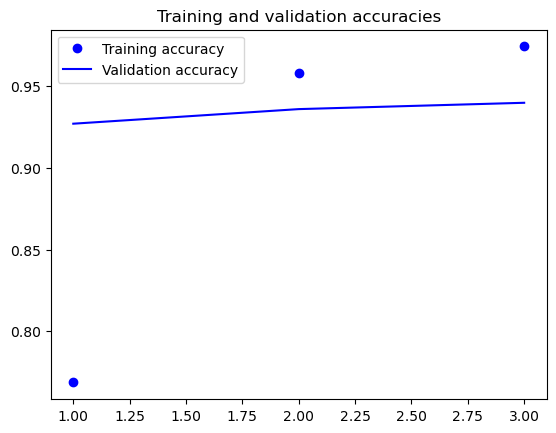

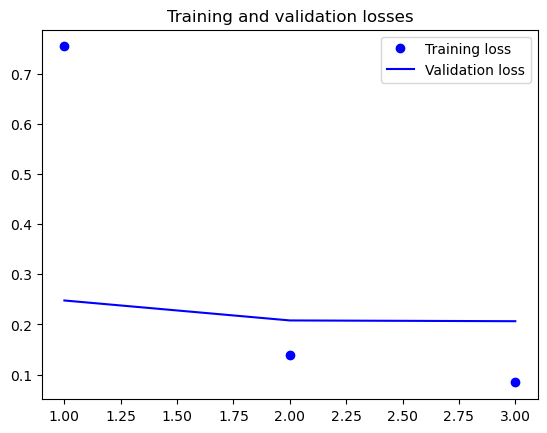

In [50]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

## Evaluation

### Evaluation

In [51]:
model.eval()

Model(
  (embeddings): Embedding(402011, 100, padding_idx=0)
  (recurrent): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=19, bias=True)
)

In [52]:
test_loss, test_acc = evaluate(model, loss_fn, test_dataloader)
test_loss, test_acc

(tensor(0.0034), 0.9429076620825148)

We reach 93.67 for two bidirectional RNN with no dropout, and 93.47  with 20% dropout, both 2 epochs

We reach 94.26 with bidirectional LSTMs 3 epochs

### We evaluate on all the test corpus

X_test

In [53]:
X_test

tensor([[388238, 187828, 165435,  ...,      0,      0,      0],
        [388238, 187828, 165435,  ...,      0,      0,      0],
        [ 43477, 380110, 244715,  ...,      0,      0,      0],
        ...,
        [119925, 362375, 237460,  ...,      0,      0,      0],
        [327638, 295628, 119925,  ...,      0,      0,      0],
        [176206, 224974,  55274,  ...,      0,      0,      0]])

In [54]:
Y_test_probs = model(X_test)

Y_test_probs

In [55]:
Y_test_probs

tensor([[[-3.3959e+00, -9.3545e-01, -7.3251e-01,  ..., -1.4152e+00,
          -5.6355e+00, -1.7583e+00],
         [-2.9747e+00, -4.0513e+00,  2.8643e+00,  ..., -1.8824e+00,
          -3.6050e+00, -1.7863e+00],
         [-4.0745e+00, -2.4476e+00, -2.8007e+00,  ...,  2.6205e+00,
          -1.3245e+00, -5.7903e-01],
         ...,
         [-2.5360e-01, -4.9747e-01, -4.9790e-02,  ..., -1.7845e+00,
           4.3864e+00, -2.4462e+00],
         [ 4.4871e-02, -3.7371e-01, -1.8699e-01,  ..., -1.4303e+00,
           3.6382e+00, -1.4923e+00],
         [ 2.0661e-01, -2.7766e-01, -2.1805e-01,  ..., -8.3089e-01,
           2.7788e+00, -7.2862e-01]],

        [[-3.3392e+00, -8.6249e-01, -6.8256e-01,  ..., -1.3250e+00,
          -5.6426e+00, -1.5558e+00],
         [-2.9259e+00, -3.8934e+00,  3.2946e+00,  ..., -1.6379e+00,
          -3.4845e+00, -1.4163e+00],
         [-4.0681e+00, -2.5418e+00, -3.3746e+00,  ...,  1.6110e+00,
          -1.6988e+00,  2.4709e-01],
         ...,
         [-2.5959e-01, -4

Y_test_hat

In [56]:
Y_test_pred = torch.argmax(Y_test_probs, dim=-1)
Y_test_pred

tensor([[11, 14, 12,  ..., 17, 17, 17],
        [11, 14, 12,  ..., 17, 17, 17],
        [13,  2, 12,  ..., 17, 17, 17],
        ...,
        [ 1,  8,  8,  ..., 17, 17, 17],
        [12, 16,  1,  ..., 17, 17, 17],
        [11, 16,  5,  ..., 17, 17, 17]])

In [57]:
Y_test_pred[:, 0]

tensor([11, 11, 13,  ...,  1, 12, 11])

In [58]:
list(map(lambda x: idx2pos.get(x.item()), Y_test_pred[0]))

['PRON',
 'SCONJ',
 'PROPN',
 'VERB',
 'ADP',
 'NOUN',
 'PUNCT',
 'NOUN',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X']

### Remove padding

In [59]:
X_test

tensor([[388238, 187828, 165435,  ...,      0,      0,      0],
        [388238, 187828, 165435,  ...,      0,      0,      0],
        [ 43477, 380110, 244715,  ...,      0,      0,      0],
        ...,
        [119925, 362375, 237460,  ...,      0,      0,      0],
        [327638, 295628, 119925,  ...,      0,      0,      0],
        [176206, 224974,  55274,  ...,      0,      0,      0]])

In [60]:
Y_test_pred_idx = []
for sent_nbr, y_test_pred in enumerate(Y_test_pred):
    Y_test_pred_idx += [y_test_pred.tolist()[:len(X_test_idx[sent_nbr])]]
print(Y_test_pred_idx[:3])

[[11, 14, 12, 16, 2, 8, 13], [11, 14, 12, 16, 2, 11, 8, 13, 8, 13, 5, 3, 8, 13, 8, 2, 6, 1, 13, 1, 8, 8, 13], [13, 2, 12, 16, 2, 12, 12, 12, 13]]


### Convert POS indices to symbols

In [61]:
Y_test_pred_pos = []
for y_test_pred_idx in Y_test_pred_idx:
    y_test_pred_pos = list(map(lambda x: idx2pos.get(x), y_test_pred_idx))
    Y_test_pred_pos += [y_test_pred_pos]
Y_test_pred_pos[:1]

[['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'NOUN', 'PUNCT']]

### Evaluate

In [62]:
total, correct, total_ukn, correct_ukn = 0, 0, 0, 0
for id_s, x_test_cat in enumerate(test_sent_words):
    for id_w, word in enumerate(x_test_cat):
        total += 1
        if Y_test_pred_pos[id_s][id_w] == test_sent_pos[id_s][id_w]:
            correct += 1
        # The word is not in the dictionary
        if word not in word2idx:
            total_ukn += 1
            if Y_test_pred_pos[id_s][id_w] == test_sent_pos[id_s][id_w]:
                correct_ukn += 1

print('total %d, correct %d, accuracy %f' %
      (total, correct, correct / total))
if total_ukn != 0:
    print('total unknown %d, correct %d, accuracy %f' %
          (total_ukn, correct_ukn, correct_ukn / total_ukn))

total 25450, correct 23997, accuracy 0.942908
total unknown 487, correct 297, accuracy 0.609856


## Prediction of parts of speech

In [63]:
def predict_sentence(sentence, model, word2idx, idx2pos, verbose=False):
    # Predict one sentence
    sentence = sentence.split()
    word_idxs = to_index([sentence], word2idx)
    pos_idx_pred = model(word_idxs[0])
    pos_idxs = torch.argmax(pos_idx_pred, dim=-1)
    pos = list(map(lambda x: idx2pos.get(x.item()), pos_idxs))
    if verbose:
        print('Sentence', sentence)
        print('Sentence word indexes', word_idxs)
        # print('Padded sentence', word_idx_padded)
        print('POS predicted', pos_idx_pred[0])
        print('POS shape', pos_idx_pred.size())
    return pos

In [64]:
sentences = ['That round table might collapse .',
             'The man can learn well .',
             'The man can swim .',
             'The man can simwo .']
for sentence in sentences:
    y_test_cat_hat = predict_sentence(sentence.lower(),
                                      model, word2idx,
                                      idx2pos)
    print(sentence)
    print(y_test_cat_hat)

That round table might collapse .
['DET', 'ADJ', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can learn well .
['DET', 'NOUN', 'AUX', 'VERB', 'ADV', 'PUNCT']
The man can swim .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can simwo .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
